In [104]:
import librosa 
import librosa.display
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tensorflow import keras 
from tensorflow.keras.preprocessing import image_dataset_from_directory, image
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [113]:
def import_test():
    datagen = ImageDataGenerator()
    new_path=Path.cwd()/'data_split'
    images_directory = new_path
    cb_test = datagen.flow_from_directory(images_directory/'test', class_mode='binary')
    return cb_test

def import_test_old_format():
    datagen = ImageDataGenerator()
    new_path=Path.cwd()/'data_split'
    images_directory = new_path
    cb_test = datagen.flow_from_directory(images_directory/'test', class_mode='binary', target_size=(97,97), batch_size=128 )
    return cb_test
    
    
def base_set_up(filename, patience=2):
    
    xx =compute_class_weight(class_weight='balanced',classes=np.unique(answers.label), y=answers.label)
    class_weight = dict(zip(np.unique(answers.label), xx))
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]

    earlystop = EarlyStopping(monitor='val_accuracy',verbose=1, patience=patience)
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', save_best_only=True,save_weights_only=False, verbose=1)
    return (class_weight, METRICS, earlystop, checkpoint)

In [120]:
results = {}

# CNN Test

In [121]:
cnn = None
keras.backend.clear_session()
filename = 'cnn_overfit2.h5'

test = import_test()
class_weight, METRICS, earlystop, checkpoint = base_set_up(filename, 5)
cnn = load_model(filename)
results['cnn_simple'] = cnn.evaluate(test)



Found 2954 images belonging to 2 classes.
93/93 [==============================] - 25s 223ms/step - loss: 0.4149 - tp: 471.0000 - fp: 418.0000 - tn: 1833.0000 - fn: 232.0000 - accuracy: 0.7800 - precision: 0.5298 - recall: 0.6700 - auc: 0.8460 - prc: 0.5931


In [143]:
cnn = None
keras.backend.clear_session()
filename = 'cnn_small_layer.h5'

test = import_test()
class_weight, METRICS, earlystop, checkpoint = base_set_up(filename, 5)
cnn = load_model(filename)
results['cnn_add_small_layer_first'] = cnn.evaluate(test)




Found 2954 images belonging to 2 classes.
93/93 [==============================] - 29s 276ms/step - loss: 1.0124 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2251.0000 - fn: 703.0000 - accuracy: 0.7620 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4745 - prc: 0.2211


In [110]:
tf.math.confusion_matrix(cnn.predict_classes(test), test.classes)

# We're seeing a lot of false negatives rather than false positives. 

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1658,  530],
       [ 593,  173]], dtype=int32)>

# VGG 19 Test
We abandoned training further, but I still want stats 


In [122]:
vgg19 = None
keras.backend.clear_session()

filename = 'vgg19-cb-2.h5'

test = import_test_old_format()
class_weight, METRICS, earlystop, checkpoint = base_set_up(filename, 5)
cnn = load_model(filename)
results['vgg19-simple'] = cnn.evaluate(test)


Found 2954 images belonging to 2 classes.
24/24 [==============================] - 164s 7s/step - loss: 0.5040 - tp: 411.0000 - fp: 521.0000 - tn: 1730.0000 - fn: 292.0000 - accuracy: 0.7248 - precision: 0.4410 - recall: 0.5846 - auc: 0.7623 - prc: 0.4355


# Resnet Test
We're gonna try multiple models for resnet since we trained multiple 

## Resnet With Smaller Dropout and 3 dense layers

In [123]:
cnn=None
keras.backend.clear_session()
filename = 'resnet-cb-3-dropout-1.h5'
test = import_test_old_format()
class_weight, METRICS, earlystop, checkpoint = base_set_up(filename, 5)
cnn = load_model(filename)
results['resnet-3-dense-1-dropout'] = cnn.evaluate(test)



Found 2954 images belonging to 2 classes.
24/24 [==============================] - 85s 3s/step - loss: 0.3604 - tp: 627.0000 - fp: 453.0000 - tn: 1798.0000 - fn: 76.0000 - accuracy: 0.8209 - precision: 0.5806 - recall: 0.8919 - auc: 0.9246 - prc: 0.7797


## Resnet original model - .5 dropout, 2 layers 

In [124]:
cnn=None
keras.backend.clear_session()
filename = 'resnet-cb.h5'
test = import_test_old_format()
class_weight, METRICS, earlystop, checkpoint = base_set_up(filename, 5)
cnn = load_model(filename)
results['resnet-2-dense-5-dropout'] = cnn.evaluate(test)




Found 2954 images belonging to 2 classes.
24/24 [==============================] - 93s 3s/step - loss: 0.3327 - tp: 519.0000 - fp: 295.0000 - tn: 1956.0000 - fn: 184.0000 - accuracy: 0.8378 - precision: 0.6376 - recall: 0.7383 - auc: 0.9137 - prc: 0.7544


# Some Graphs

In [125]:
import seaborn as sns


In [145]:
xx = pd.DataFrame(results).transpose().reset_index()
xx.columns=['model','loss','tp','fp','tn','fn','accuracy','precision','recall','auc','prc']

<AxesSubplot:xlabel='auc', ylabel='recall'>

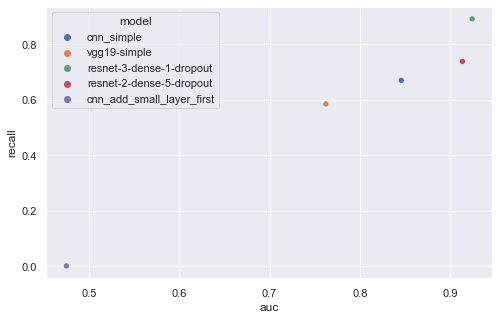

In [147]:
sns.set(rc={'figure.figsize':(8,5)})
sns.scatterplot(data=xx, x='auc',y='recall',hue='model')